In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x +5

In [5]:
f(3.0)

20.0

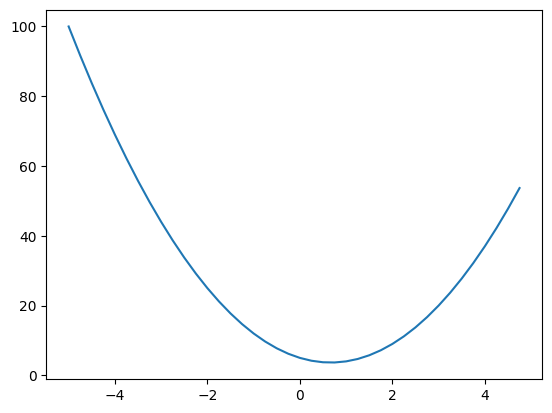

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x)) / h

0.0

In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c
a += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c
b += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c
c += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


# Mircrograd

class Value:
    def __init__(self, data, _children=(), _op='', label=''):   # Constructor
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):         # like a toString
        return f"Value(data={self.data})" 
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

        

In [36]:

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.label = label
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [37]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label="f")
L = d*f; L.label = 'L'
L

Value(data=-8.0, grad=0)

In [38]:
d._prev

{Value(data=-6.0, grad=0), Value(data=10.0, grad=0)}

In [39]:
d._op

'+'

# Visualizer Code

In [47]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set() # edges are set of pairs
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v)) 
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    # print(n1,n2)
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

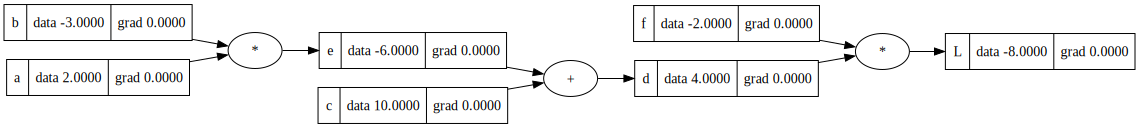

In [48]:
draw_dot(L)

Multiply - do power rule
Add - just copy since it will just be mutiplied by 1
Backprop - Chain Rule, just multiply

In [42]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label="f")
    L = d*f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label="f") 
    L = d*f; L.label = 'L'

    L2 = L.data + h

    out = (L2-L1)/h
    print(out)

lol()
    

0.9999999999976694


We don't need to be very atomic with MLP it is really upto us

As long as we know how to compute the local derivative


It is amazing how I can store functions / different functions to be run later

which in this case the backward() 
storing it as backward stores it as afuncirton
storing it as backward made it runnable when the variable is called with ()
for example

n.backward()








Topological sort

1:50 at this time
all inputs for neurons are still the same


In [43]:
import random

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) # for each input
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons] # For each neurons in the layer
        return out[0] if len(out) == 1 else out
    # Loops through all parameters of each neuron of the layer
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()] 
        

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers: # For each layer
            x = layer(x) # replaces the x with the output of the previous layer
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.15203620430798312, grad=0)

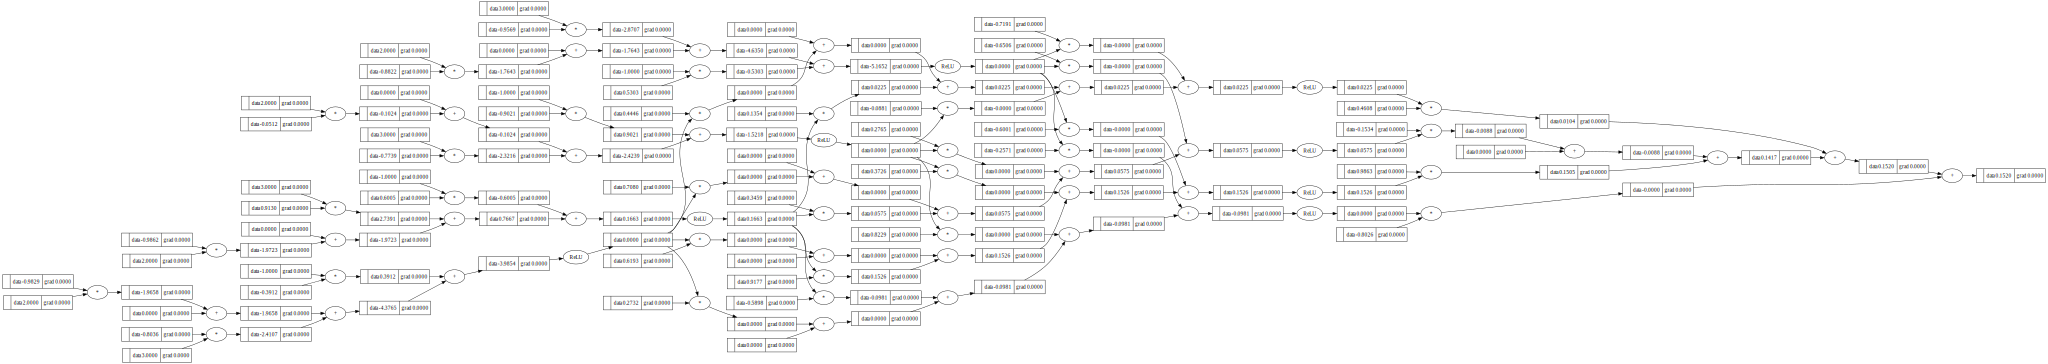

In [44]:
draw_dot(n(x))

Forgetting to zero_grad()

In 5 mins time, Knowing how micrograd work what are my top bet on how to sovle AI Alignment

1. We need a new idea to align it with our values but how we don't even know how values are represented into our brain or MLP
2. We need better understanding, once we understand then hopefully someone could find an idea on how to solve it

Mech Interp Ideas/Actions

1.
2. Understand TMoS
3. Guess why they recommend those techniques to reduce Superposition
4. Try to converse with them
5. Watch the video
6. 

Within 5 mins, give ideas for Mech Interp 

1. Reduce polysemanticity
2. Train to minimize polysemanticity
3. Concretecize what is a feature, is it really necessary to concretecize it
4. Why we need MechInterp, to better black box, to make it as similar as human language what AI is saying even though we learn differently
5. Measure what needed to be measure like deception or malice
6. then make AI avoid them, or not maximize for them.


1. We should be careful on how we measure this, to not meeasure what we want but to measure what actually it is.
2. But I could also approach it like code. Small imperfect progress are better. Moving will help point better to the right direction.

1. I want to read more about Mech Interp.

I could twt this if I want

Reason why I could do this

1. Interested
2. Pretty good at spacial recognition
3. Pretty good at problem solving
4. 

AI already understand different meanings of bridges.

Now it is easier for my head to wrap around what MLP is actually is

Love it!

Also, I just want to acknowledge how much I'm enjoying my work rn. I love solving problems specially when it will matter to people around me. 

Love making progress